In [ ]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 28.3 MB/s eta 0:00:00


In [ ]:
!pip install pyqubo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 56.2 MB/s eta 0:00:00


In [ ]:
!pip install dwave-neal

In [ ]:
from pulp import LpVariable, LpMinimize, LpProblem, LpBinary

# Sample Data
M = 4
N = 4
S = [[0, 1, 0,1], [1, 0, 1,0],[1,0,0,1], [0, 1, 0,1]]  # Similarity matrix

prob = LpProblem("AdScheduling", LpMinimize)

# Define Decision Variables
x = LpVariable.dicts("x", (range(M), range(N)), cat='Binary')
y = LpVariable.dicts("y", (range(M), range(M), range(N)), cat='Binary')

# Objective Function
objective = sum(S[i][k] * y[i][k][j] for i in range(M) for k in range(M) for j in range(N))
prob += objective

# Constraints:
for i in range(M):
    for k in range(M):
        for j in range(N):
            prob += y[i][k][j] <= x[i][j]#in one slot we cannot have 2 ads
            prob += y[i][k][j] <= x[k][j]#iin 1 ad cannot be repeated in multiple slot at same time
            prob += y[i][k][j] >= x[i][j] + x[k][j] - 1#no repeatation in one slot
            prob += y[i][k][j] != x[i][i] or x[j][j] or x[k][k]

for i in range(M):
    prob += sum(x[i][j] for j in range(N)) == 1

prob.solve()


for i in range(M):
    for j in range(N):
        if x[i][j].value() == 1:
            print(f"Advertisement {i} is scheduled in slot {j}")
arr = []
for i in range(M):
    for j in range(N):
        #x[i][j].value().int
        arr.append(x[i][j].value())
        ## x[0][1] = 1
print(arr)

Advertisement 0 is scheduled in slot 3
Advertisement 1 is scheduled in slot 2
Advertisement 2 is scheduled in slot 0
Advertisement 3 is scheduled in slot 1
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]


In [ ]:
from pyqubo import Array
from neal import SimulatedAnnealingSampler

# Sample Data
M = 4  # Number of advertisements
N = 5  # Number of ad slots in a break
S = [[0, 1, 0,1], [1, 0, 1,0],[1,0,0,1], [0, 1, 0,1]]

x = Array.create('x', shape=(M, N), vartype="BINARY")

# Objective Function:
objective = sum(S[i][k] * x[i][j] * x[k][j] for i in range(M) for k in range(M) for j in range(N))

constraints = [sum(x[i][j] for j in range(N)) - 1 for i in range(M)]

H = objective + sum(constraint**2 for constraint in constraints)

model = H.compile()
qubo, offset = model.to_qubo()

sampler = SimulatedAnnealingSampler()
response = sampler.sample_qubo(qubo)
solution = response.first.sample

decoded_solution = model.decode_sample(solution, vartype="BINARY")

print(decoded_solution)

for i in range(M):
    for j in range(N):
        if decoded_solution.array('x', (i, j)) == 1:
            print(f"Advertisement {i} is scheduled in slot {j}")


DecodedSolution({x[3][1]:0, x[3][3]:0, x[3][0]:0, x[2][4]:0, x[2][3]:1, x[3][2]:0, x[2][2]:0, x[2][0]:0, x[1][4]:0, x[3][4]:1, x[2][1]:0, x[1][1]:1, x[1][0]:0, x[0][4]:0, x[0][2]:1, x[1][2]:0, x[0][3]:0, x[0][1]:0, x[1][3]:0, x[0][0]:0}, energy=1.000000)
Advertisement 0 is scheduled in slot 2
Advertisement 1 is scheduled in slot 1
Advertisement 2 is scheduled in slot 3
Advertisement 3 is scheduled in slot 4


In [ ]:
from pyqubo import Array
from neal import SimulatedAnnealingSampler

# Sample data
ads = [
    {"name": "ZARA", "duration": 15, "time": "06:18:45"},
    {"name": "H&M", "duration": 15, "time": "06:07:35"},
    {"name": "Levis", "duration": 10, "time": "06:19:35"},
    {"name": "Rupa frontline", "duration": 10, "time": "06:08:40"},
    {"name": "J&J", "duration": 10, "time": "06:19:05"},
    {"name": "Fuaark", "duration": 10, "time": "06:08:30"}
]

M = len(ads)
N = len(set(ad["time"] for ad in ads)


       )

S = [[1 if ads[i]["name"] == ads[j]["name"] and i != j else 0 for j in range(M)] for i in range(M)]

x = Array.create('x', shape=(M, N), vartype="BINARY")

# Objective Function:
objective = sum(S[i][k] * x[i][j] * x[k][j] for i in range(M) for k in range(M) for j in range(N))

constraints = [sum(x[i][j] for j in range(N)) - 1 for i in range(M)]

H = objective + sum(constraint**2 for constraint in constraints)

model = H.compile()
qubo, offset = model.to_qubo()

sampler = SimulatedAnnealingSampler()
response = sampler.sample_qubo(qubo)
solution = response.first.sample

decoded_solution = model.decode_sample(solution, vartype="BINARY")

for i in range(M):
    for j in range(N):
        if decoded_solution.array('x', (i, j)) == 1:
            print(f"Advertisement '{ads[i]['name']}' scheduled at {ads[i]['time']} is placed in slot {j}")


Advertisement 'ZARA' scheduled at 06:18:45 is placed in slot 3
Advertisement 'H&M' scheduled at 06:07:35 is placed in slot 2
Advertisement 'Levis' scheduled at 06:19:35 is placed in slot 3
Advertisement 'Rupa frontline' scheduled at 06:08:40 is placed in slot 4
Advertisement 'J&J' scheduled at 06:19:05 is placed in slot 4
Advertisement 'Fuaark' scheduled at 06:08:30 is placed in slot 2


In [ ]:
# Extracting relevant data from the provided dataset
ads = [
    {"product": "ZARA", "duration": 15, "time": "06:18:45"},
    {"product": "H&M", "duration": 15, "time": "06:07:35"},
    {"product": "Levis", "duration": 10, "time": "06:19:35"},
    {"product": "Rupa frontline", "duration": 10, "time": "06:08:40"},
    {"product": "J&J", "duration": 10, "time": "06:19:05"},
    {"product": "Fuaark", "duration": 10, "time": "06:08:30"}
]

In [ ]:
from pyqubo import Array
from neal import SimulatedAnnealingSampler

M = len(ads)
N = len(set(ad["time"] for ad in ads))

S = [[1 if ads[i]["product"] == ads[j]["product"] and i != j else 0 for j in range(M)] for i in range(M)]

x = Array.create('x', shape=(M, N), vartype="BINARY")
objective = sum(S[i][k] * x[i][j] * x[k][j] for i in range(M) for k in range(M) for j in range(N))

constraints = [sum(x[i][j] for j in range(N)) - 1 for i in range(M)]


H = objective + sum(constraint**2 for constraint in constraints)

model = H.compile()
qubo, offset = model.to_qubo()

sampler = SimulatedAnnealingSampler()
response = sampler.sample_qubo(qubo)
solution = response.first.sample

decoded_solution = model.decode_sample(solution, vartype="BINARY")

for i in range(M):
    for j in range(N):
        if decoded_solution.array('x', (i, j)) == 1:
            print(f"Advertisement for product '{ads[i]['product']}' scheduled at {ads[i]['time']} is placed in slot {j}")


Advertisement for product 'ZARA' scheduled at 06:18:45 is placed in slot 0
Advertisement for product 'H&M' scheduled at 06:07:35 is placed in slot 4
Advertisement for product 'Levis' scheduled at 06:19:35 is placed in slot 5
Advertisement for product 'Rupa frontline' scheduled at 06:08:40 is placed in slot 2
Advertisement for product 'J&J' scheduled at 06:19:05 is placed in slot 5
Advertisement for product 'Fuaark' scheduled at 06:08:30 is placed in slot 2


In [ ]:
from pyqubo import Array
from neal import SimulatedAnnealingSampler

# Sample Data
M = 4  # Number of advertisements
N = 4  # Number of ad slots in a break
S = [[0, 1, 0,1], [1, 0, 1,0],[1,0,0,1], [0, 1, 0,1]]

x = Array.create('x', shape=(M, N), vartype="BINARY")

# Objective Function:
objective = sum(S[i][k] * x[i][j] * x[k][j] for i in range(M) for k in range(M) for j in range(N))

constraints = [sum(x[i][j] for j in range(N)) - 1 for i in range(M)]

H = objective + sum(constraint**2 for constraint in constraints)

model = H.compile()
qubo, offset = model.to_qubo()
print(qubo)

sampler = SimulatedAnnealingSampler()
response = sampler.sample_qubo(qubo)
solution = response.first.sample

decoded_solution = model.decode_sample(solution, vartype="BINARY")

for i in range(M):
    for j in range(N):
        if decoded_solution.array('x', (i, j)) == 1:
            print(f"Advertisement {i} is scheduled in slot {j}")

print (decoded_solution)
print (solution)

{('x[1][3]', 'x[1][0]'): 2.0, ('x[1][1]', 'x[0][1]'): 2.0, ('x[0][2]', 'x[0][1]'): 2.0, ('x[1][0]', 'x[1][0]'): -1.0, ('x[3][3]', 'x[2][3]'): 1.0, ('x[2][3]', 'x[2][0]'): 2.0, ('x[2][3]', 'x[2][1]'): 2.0, ('x[2][1]', 'x[1][1]'): 1.0, ('x[1][1]', 'x[1][1]'): -1.0, ('x[1][3]', 'x[1][2]'): 2.0, ('x[3][2]', 'x[3][0]'): 2.0, ('x[2][1]', 'x[2][0]'): 2.0, ('x[3][2]', 'x[1][2]'): 1.0, ('x[1][0]', 'x[0][0]'): 2.0, ('x[2][1]', 'x[2][1]'): -1.0, ('x[0][2]', 'x[0][0]'): 2.0, ('x[3][1]', 'x[2][1]'): 1.0, ('x[0][3]', 'x[0][2]'): 2.0, ('x[3][2]', 'x[0][2]'): 1.0, ('x[3][0]', 'x[2][0]'): 1.0, ('x[3][1]', 'x[3][0]'): 2.0, ('x[3][2]', 'x[3][1]'): 2.0, ('x[3][3]', 'x[0][3]'): 1.0, ('x[3][3]', 'x[3][2]'): 2.0, ('x[1][3]', 'x[0][3]'): 2.0, ('x[3][0]', 'x[1][0]'): 1.0, ('x[1][2]', 'x[1][0]'): 2.0, ('x[1][3]', 'x[1][3]'): -1.0, ('x[0][1]', 'x[0][1]'): -1.0, ('x[1][2]', 'x[0][2]'): 2.0, ('x[0][3]', 'x[0][3]'): -1.0, ('x[1][1]', 'x[1][0]'): 2.0, ('x[2][1]', 'x[0][1]'): 1.0, ('x[0][3]', 'x[0][1]'): 2.0, ('x[0][

In [ ]:
pip install qiskit==0.46.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 12.5 MB/s eta 0:00:00


In [ ]:
pip install qiskit-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.6/635.6 kB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for docplex: filename=docplex-2.27.239-py3-none-any.whl size=674503 sha256=9341ff09d19c6921970c876787ac6cd9f42feadd0b0618f19b34e5374e0746f2
  Stored in directory: /root/.cache/pip/wheels/62/7c/db/cef9425e1cedbf45621545097eaaeed5efe07005bd8229dd74
Successfully built docplex


In [ ]:
import qiskit

In [ ]:
qiskit.__qiskit_version__

{'qiskit': '0.46.0', 'qiskit-aer': None, 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.6.1', 'qiskit-machine-learning': None}

In [ ]:
import numpy as np
import copy
import qiskit_algorithms

# Problem modelling imports
from docplex.mp.model import Model

import qiskit_algorithms

# Qiskit imports
from qiskit_algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer

<ipython-input-14-6b156dffe5b1>:12: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


In [ ]:
import numpy as np
def create_problem(s, M: int = 3, N: int = 5):
    """Solve the quadratic program using docplex."""

    mdl = Model()
    x = [[mdl.binary_var(f"x{i}_{j}") for j in range(len(s))] for i in range(len(s))]

    # Define the objective and constraints
    objective = mdl.sum(s[i][k] * x[i][j] * x[k][j] for i in range(len(s)) for k in range(len(s)) for j in range(len(s)))
    constraints = [mdl.sum(x[i][j] for j in range(len(s))) == 1 for i in range(len(s))]

    # Add objective and constraints to the model
    mdl.minimize(objective)
    mdl.add_constraints(constraints)

    qp = from_docplex_mp(mdl)
    return qp


def relax_problem(problem):
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem


In [ ]:
M = 4  # Number of advertisements
N = 4  # Number of ad slots in a break
S = [[0, 1, 0,1], [1, 0, 1,0],[1,0,0,1], [0, 1, 0,1]]
s = np.array(S)

In [ ]:
qubo = create_problem(s, M, N)
print(qubo.prettyprint())

Problem name: docplex_model1

Minimize
  2*x0_0*x1_0 + x0_0*x2_0 + x0_0*x3_0 + 2*x0_1*x1_1 + x0_1*x2_1 + x0_1*x3_1
  + 2*x0_2*x1_2 + x0_2*x2_2 + x0_2*x3_2 + 2*x0_3*x1_3 + x0_3*x2_3 + x0_3*x3_3
  + x1_0*x2_0 + x1_0*x3_0 + x1_1*x2_1 + x1_1*x3_1 + x1_2*x2_2 + x1_2*x3_2
  + x1_3*x2_3 + x1_3*x3_3 + x2_0*x3_0 + x2_1*x3_1 + x2_2*x3_2 + x2_3*x3_3
  + x3_0^2 + x3_1^2 + x3_2^2 + x3_3^2

Subject to
  Linear constraints (4)
    x0_0 + x0_1 + x0_2 + x0_3 == 1  'c0'
    x1_0 + x1_1 + x1_2 + x1_3 == 1  'c1'
    x2_0 + x2_1 + x2_2 + x2_3 == 1  'c2'
    x3_0 + x3_1 + x3_2 + x3_3 == 1  'c3'

  Binary variables (16)
    x0_0 x0_1 x0_2 x0_3 x1_0 x1_1 x1_2 x1_3 x2_0 x2_1 x2_2 x2_3 x3_0 x3_1 x3_2
    x3_3



In [ ]:
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer

In [ ]:
qubo = create_problem(s, M, N)
print(qubo.prettyprint())

Problem name: docplex_model2

Minimize
  2*x0_0*x1_0 + x0_0*x2_0 + x0_0*x3_0 + 2*x0_1*x1_1 + x0_1*x2_1 + x0_1*x3_1
  + 2*x0_2*x1_2 + x0_2*x2_2 + x0_2*x3_2 + 2*x0_3*x1_3 + x0_3*x2_3 + x0_3*x3_3
  + x1_0*x2_0 + x1_0*x3_0 + x1_1*x2_1 + x1_1*x3_1 + x1_2*x2_2 + x1_2*x3_2
  + x1_3*x2_3 + x1_3*x3_3 + x2_0*x3_0 + x2_1*x3_1 + x2_2*x3_2 + x2_3*x3_3
  + x3_0^2 + x3_1^2 + x3_2^2 + x3_3^2

Subject to
  Linear constraints (4)
    x0_0 + x0_1 + x0_2 + x0_3 == 1  'c0'
    x1_0 + x1_1 + x1_2 + x1_3 == 1  'c1'
    x2_0 + x2_1 + x2_2 + x2_3 == 1  'c2'
    x3_0 + x3_1 + x3_2 + x3_3 == 1  'c3'

  Binary variables (16)
    x0_0 x0_1 x0_2 x0_3 x1_0 x1_1 x1_2 x1_3 x2_0 x2_1 x2_2 x2_3 x3_0 x3_1 x3_2
    x3_3



In [ ]:
pip install cplex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 13.0 MB/s eta 0:00:00


In [ ]:
!pip install qiskit-optimization[cplex]

In [ ]:
print(arr)

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]


In [ ]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA()

In [ ]:
qp = relax_problem(QuadraticProgramToQubo().convert(qubo))
print(qp.prettyprint())

Problem name: docplex_model2

Minimize
  33*x0_0^2 + 66*x0_0*x0_1 + 66*x0_0*x0_2 + 66*x0_0*x0_3 + 2*x0_0*x1_0
  + x0_0*x2_0 + x0_0*x3_0 + 33*x0_1^2 + 66*x0_1*x0_2 + 66*x0_1*x0_3
  + 2*x0_1*x1_1 + x0_1*x2_1 + x0_1*x3_1 + 33*x0_2^2 + 66*x0_2*x0_3 + 2*x0_2*x1_2
  + x0_2*x2_2 + x0_2*x3_2 + 33*x0_3^2 + 2*x0_3*x1_3 + x0_3*x2_3 + x0_3*x3_3
  + 33*x1_0^2 + 66*x1_0*x1_1 + 66*x1_0*x1_2 + 66*x1_0*x1_3 + x1_0*x2_0
  + x1_0*x3_0 + 33*x1_1^2 + 66*x1_1*x1_2 + 66*x1_1*x1_3 + x1_1*x2_1 + x1_1*x3_1
  + 33*x1_2^2 + 66*x1_2*x1_3 + x1_2*x2_2 + x1_2*x3_2 + 33*x1_3^2 + x1_3*x2_3
  + x1_3*x3_3 + 33*x2_0^2 + 66*x2_0*x2_1 + 66*x2_0*x2_2 + 66*x2_0*x2_3
  + x2_0*x3_0 + 33*x2_1^2 + 66*x2_1*x2_2 + 66*x2_1*x2_3 + x2_1*x3_1 + 33*x2_2^2
  + 66*x2_2*x2_3 + x2_2*x3_2 + 33*x2_3^2 + x2_3*x3_3 + 34*x3_0^2 + 66*x3_0*x3_1
  + 66*x3_0*x3_2 + 66*x3_0*x3_3 + 34*x3_1^2 + 66*x3_1*x3_2 + 66*x3_1*x3_3
  + 34*x3_2^2 + 66*x3_2*x3_3 + 34*x3_3^2 - 66*x0_0 - 66*x0_1 - 66*x0_2 - 66*x0_3
  - 66*x1_0 - 66*x1_1 - 66*x1_2 - 66*x1_3 - 66*x2_0

In [ ]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qubo)
print(qubo.prettyprint())
op, offset = qubo.to_ising()
print("offfset is ", offset)
#qubit_hamiltonian = op

Problem name: docplex_model2

Minimize
  33*x0_0^2 + 66*x0_0*x0_1 + 66*x0_0*x0_2 + 66*x0_0*x0_3 + 2*x0_0*x1_0
  + x0_0*x2_0 + x0_0*x3_0 + 33*x0_1^2 + 66*x0_1*x0_2 + 66*x0_1*x0_3
  + 2*x0_1*x1_1 + x0_1*x2_1 + x0_1*x3_1 + 33*x0_2^2 + 66*x0_2*x0_3 + 2*x0_2*x1_2
  + x0_2*x2_2 + x0_2*x3_2 + 33*x0_3^2 + 2*x0_3*x1_3 + x0_3*x2_3 + x0_3*x3_3
  + 33*x1_0^2 + 66*x1_0*x1_1 + 66*x1_0*x1_2 + 66*x1_0*x1_3 + x1_0*x2_0
  + x1_0*x3_0 + 33*x1_1^2 + 66*x1_1*x1_2 + 66*x1_1*x1_3 + x1_1*x2_1 + x1_1*x3_1
  + 33*x1_2^2 + 66*x1_2*x1_3 + x1_2*x2_2 + x1_2*x3_2 + 33*x1_3^2 + x1_3*x2_3
  + x1_3*x3_3 + 33*x2_0^2 + 66*x2_0*x2_1 + 66*x2_0*x2_2 + 66*x2_0*x2_3
  + x2_0*x3_0 + 33*x2_1^2 + 66*x2_1*x2_2 + 66*x2_1*x2_3 + x2_1*x3_1 + 33*x2_2^2
  + 66*x2_2*x2_3 + x2_2*x3_2 + 33*x2_3^2 + x2_3*x3_3 + 34*x3_0^2 + 66*x3_0*x3_1
  + 66*x3_0*x3_2 + 66*x3_0*x3_3 + 34*x3_1^2 + 66*x3_1*x3_2 + 66*x3_1*x3_3
  + 34*x3_2^2 + 66*x3_2*x3_3 + 34*x3_3^2 - 66*x0_0 - 66*x0_1 - 66*x0_2 - 66*x0_3
  - 66*x1_0 - 66*x1_1 - 66*x1_2 - 66*x1_3 - 66*x2_0

In [ ]:
pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=293993f79bf0bdd2255bd5cf4fa52cf992c06d167ca4b191d77e18934be95099
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [ ]:
pip install matplotlib

In [ ]:
!pip install pylatexenc

In [ ]:
import pylatexenc

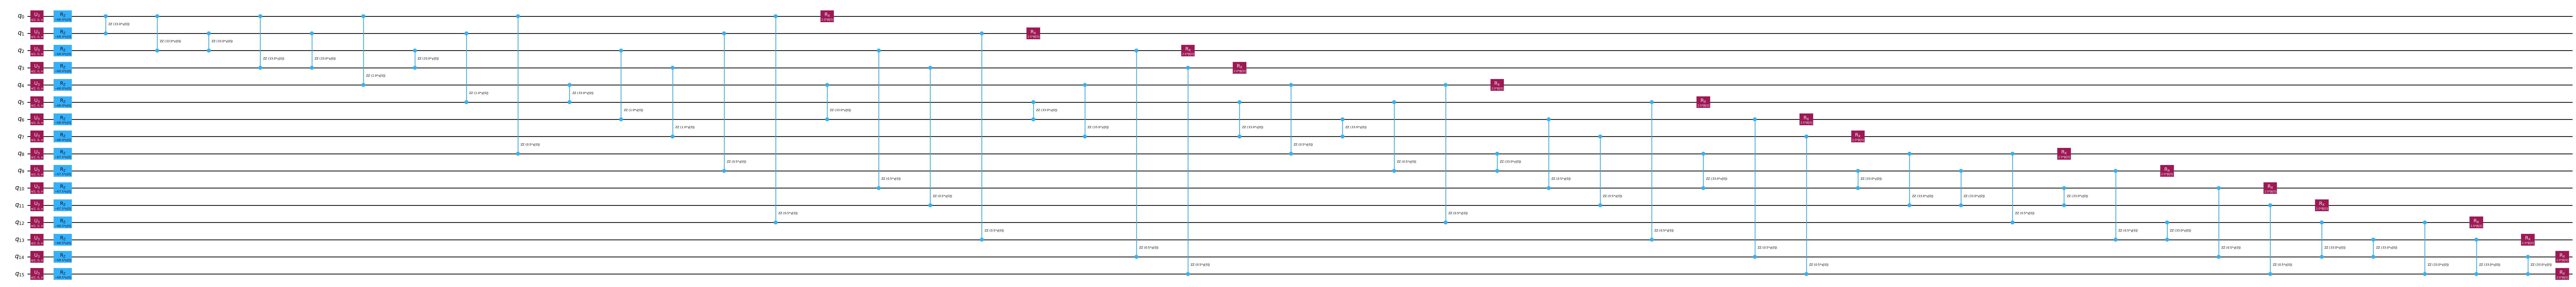

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz

qubit_hamiltonian = op
qaoa_ansatz = QAOAAnsatz(cost_operator=qubit_hamiltonian, reps=1, initial_state=None, mixer_operator=None, name='QAOA')
qaoa_ansatz.decompose().decompose().decompose().draw(output='mpl', scale=1.0, fold=-10, style = "iqp")

In [ ]:
import numpy as np
import copy
from docplex.mp.model import Model
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.translators import from_docplex_mp

# Define a function to create the quadratic program using DOcplex
def create_problem(mu: np.array, sigma: np.array, total: int = 3) -> QuadraticProgram:
    mdl = Model()
    x = [mdl.binary_var(f"x{i}") for i in range(len(sigma))]

    objective = mdl.sum([mu[i] * x[i] for i in range(len(mu))])
    objective -= 2 * mdl.sum([sigma[i, j] * x[i] * x[j] for i in range(len(mu)) for j in range(len(mu))])
    mdl.maximize(objective)

    cost = mdl.sum(x)
    mdl.add_constraint(cost == total)

    qp = from_docplex_mp(mdl)
    return qp

# Define a function to relax the problem by changing variables to continuous
def relax_problem(problem) -> QuadraticProgram:
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem

# Main execution
mu = np.array([3.418, 2.0913, 6.2415, 4.4436, 10.892, 3.4051])
sigma = np.array([[1.07978412, 0.00768914, 0.11227606, -0.06842969, -0.01016793, -0.00839765],
                   [0.00768914, 0.10922887, -0.03043424, -0.0020045, 0.00670929, 0.0147937],
                   [0.11227606, -0.03043424, 0.985353, 0.02307313, -0.05249785, 0.00904119],
                   [-0.06842969, -0.0020045, 0.02307313, 0.6043817, 0.03740115, -0.00945322],
                   [-0.01016793, 0.00670929, -0.05249785, 0.03740115, 0.79839634, 0.07616951],
                   [-0.00839765, 0.0147937, 0.00904119, -0.00945322, 0.07616951, 1.08464544]])

# Create the original binary problem
qubo = create_problem(mu, sigma)
print("Original Binary Problem:")
print(qubo.prettyprint())

# Solve the original binary problem classically
result = CplexOptimizer().solve(qubo)
print("\nClassical Solution to Binary Problem:")
print(result.prettyprint())

# Relax the problem by changing variables to continuous
relaxed_qubo = relax_problem(QuadraticProgramToQubo().convert(qubo))
print("\nRelaxed Continuous Problem:")
print(relaxed_qubo.prettyprint())

# Solve the relaxed continuous problem classically
sol = CplexOptimizer().solve(relaxed_qubo)
print("\nClassical Solution to Relaxed Continuous Problem:")
print(sol.prettyprint())

# Use the solution to the relaxed problem to warm-start QAOA
thetas = [2 * np.arcsin(np.sqrt(c_star)) for c_star in sol.samples[0].x]
init_qc = QuantumCircuit(len(sigma))
for idx, theta in enumerate(thetas):
    init_qc.ry(theta, idx)

# Apply QAOA to the original binary problem with warm-start
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 1.0])
qaoa = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = qaoa.solve(qubo)
print("\nQAOA Solution to Binary Problem:")
print(qaoa_result.prettyprint())

# Apply Warm-Start QAOA to the original binary problem
ws_qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_state=init_qc, initial_point=[0.0, 1.0])
ws_qaoa = MinimumEigenOptimizer(ws_qaoa_mes)
ws_qaoa_result = ws_qaoa.solve(qubo)
print("\nWarm-Start QAOA Solution to Binary Problem:")
print(ws_qaoa_result.prettyprint())

Original Binary Problem:
Problem name: docplex_model6

Maximize
  -2.15956824*x0^2 - 0.03075656*x0*x1 - 0.44910424*x0*x2 + 0.27371876*x0*x3
  + 0.04067172*x0*x4 + 0.0335906*x0*x5 - 0.21845774*x1^2 + 0.12173696*x1*x2
  + 0.008018*x1*x3 - 0.02683716*x1*x4 - 0.0591748*x1*x5 - 1.970706*x2^2
  - 0.09229252*x2*x3 + 0.2099914*x2*x4 - 0.03616476*x2*x5 - 1.2087634*x3^2
  - 0.1496046*x3*x4 + 0.03781288*x3*x5 - 1.59679268*x4^2 - 0.30467804*x4*x5
  - 2.16929088*x5^2 + 3.418*x0 + 2.0913*x1 + 6.2415*x2 + 4.4436*x3 + 10.892*x4
  + 3.4051*x5

Subject to
  Linear constraints (1)
    x0 + x1 + x2 + x3 + x4 + x5 == 3  'c0'

  Binary variables (6)
    x0 x1 x2 x3 x4 x5


Classical Solution to Binary Problem:
objective function value: 16.7689322
variable values: x0=0.0, x1=0.0, x2=1.0, x3=1.0, x4=1.0, x5=0.0
status: SUCCESS

Relaxed Continuous Problem:
Problem name: docplex_model6

Minimize
  44.84880018*x0^2 + 85.40922044*x0*x1 + 85.82756812*x0*x2
  + 85.10474511999999*x0*x3 + 85.33779215999999*x0*x4 + 85